# Multi-Label Node Classification with GNNs
# Course Project: Graph Neural Networks for Biological Network Analysis

**Author:** Complex Network Analysis Project  
**Date:** December 8, 2025

---

## Project Overview

This notebook implements a comprehensive solution for **multi-label node classification** on a biological network using Graph Neural Networks (GNNs). The goal is to predict 305 binary labels for test nodes.

### Models Implemented:
1. **GraphSAGE** - Inductive neighborhood sampling
2. **GAT (Graph Attention Network)** - Attention-based aggregation
3. **GCN (Graph Convolutional Network)** - Spectral-based approach

### Advanced Techniques:
- **Label Reuse**: Training labels as input features
- **Correct-and-Smooth (C&S)**: Post-processing predictions
- **Log-degree features**: Graph topology information
- **Weighted BCE Loss**: Handle label imbalance
- **Feature preprocessing**: NaN imputation and standardization

### Evaluation:
- Metric: **Average Precision (AP)** across all labels
- Train/Validation split for model selection
- Final evaluation on test set with submission generation

---

## 1. Environment Setup and Imports

Import all necessary libraries for GNN implementation, training, and evaluation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import degree

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5090


## 2. Data Loading and Exploration

Load the graph data (node features, edge indices, labels) and explore the dataset structure.

In [2]:
# Load data from .pt files
data_dir = '../data/'

# Load tensors
edge_index = torch.load(data_dir + 'edge_index.pt')
node_features = torch.load(data_dir + 'node_features.pt')
y = torch.load(data_dir + 'y.pt')
train_idx = torch.load(data_dir + 'train_idx.pt')
test_idx = torch.load(data_dir + 'test_idx.pt')

# Load sample submission to understand format
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print(f"\n📊 Graph Structure:")
print(f"  - Number of nodes: {node_features.shape[0]:,}")
print(f"  - Number of edges: {edge_index.shape[1]:,}")
print(f"  - Original feature dimension: {node_features.shape[1]}")
print(f"\n🏷️  Labels:")
print(f"  - Number of labels: {y.shape[1]}")
print(f"  - Labels shape: {y.shape}")
print(f"\n📈 Data Splits:")
print(f"  - Training nodes: {len(train_idx):,}")
print(f"  - Test nodes: {len(test_idx):,}")
print(f"  - Train/Total ratio: {len(train_idx)/node_features.shape[0]:.2%}")

# Analyze label distribution
print(f"\n📊 Label Statistics (on training data):")
train_labels = y[train_idx]
labels_per_node = train_labels.sum(dim=1)
pos_per_label = train_labels.sum(dim=0)

print(f"  - Mean labels per node: {labels_per_node.float().mean():.2f}")
print(f"  - Median labels per node: {labels_per_node.float().median():.2f}")
print(f"  - Max labels per node: {labels_per_node.max():.0f}")
print(f"  - Min positive samples per label: {pos_per_label.min():.0f}")
print(f"  - Max positive samples per label: {pos_per_label.max():.0f}")
print(f"  - Mean positive samples per label: {pos_per_label.float().mean():.2f}")

# Check for missing values in features
nan_count = torch.isnan(node_features).sum().item()
print(f"\n⚠️  Missing values in features: {nan_count:,} ({nan_count/(node_features.numel())*100:.2f}%)")

print("\n" + "=" * 80)

DATA OVERVIEW

📊 Graph Structure:
  - Number of nodes: 19,765
  - Number of edges: 1,554,790
  - Original feature dimension: 37

🏷️  Labels:
  - Number of labels: 305
  - Labels shape: torch.Size([19765, 305])

📈 Data Splits:
  - Training nodes: 5,046
  - Test nodes: 3,365
  - Train/Total ratio: 25.53%

📊 Label Statistics (on training data):
  - Mean labels per node: 9.26
  - Median labels per node: 6.00
  - Max labels per node: 109
  - Min positive samples per label: 16
  - Max positive samples per label: 492
  - Mean positive samples per label: 153.18

⚠️  Missing values in features: 506 (0.07%)



## 3. Feature Preprocessing

Implement comprehensive feature preprocessing:
1. **NaN Imputation**: Fill missing values with median
2. **Standardization**: Z-score normalization for continuous features
3. **Log-Degree Features**: Add graph topology information
4. **Label Reuse Features**: Incorporate known labels for training nodes

In [3]:
class FeaturePreprocessor:
    """
    Comprehensive feature preprocessing pipeline for GNN input.
    
    Techniques applied:
    1. NaN imputation (median strategy)
    2. Feature standardization (z-score normalization)
    3. Log-degree feature engineering
    4. Label reuse (semi-supervised trick)
    """
    
    def __init__(self, edge_index, node_features, y, train_idx):
        """
        Initialize preprocessor with graph data.
        
        Args:
            edge_index: Edge connectivity [2, num_edges]
            node_features: Original node features [num_nodes, num_features]
            y: Labels [num_nodes, num_labels]
            train_idx: Indices of training nodes
        """
        self.edge_index = edge_index
        self.node_features = node_features.clone()
        self.y = y
        self.train_idx = train_idx
        self.scaler = StandardScaler()
        
    def impute_nans(self):
        """Impute NaN values using median of training data."""
        print("🔧 Imputing NaN values...")
        
        # Calculate median from training nodes only
        train_features = self.node_features[self.train_idx]
        
        # For each feature, compute median and fill NaNs
        for i in range(self.node_features.shape[1]):
            col = train_features[:, i]
            if torch.isnan(col).any():
                median_val = col[~torch.isnan(col)].median()
                self.node_features[:, i] = torch.where(
                    torch.isnan(self.node_features[:, i]),
                    median_val,
                    self.node_features[:, i]
                )
        
        nan_remaining = torch.isnan(self.node_features).sum().item()
        print(f"   ✓ NaN values remaining: {nan_remaining}")
        
    def standardize_features(self):
        """Standardize features using training data statistics."""
        print("🔧 Standardizing features...")
        
        # Fit scaler on training data only
        train_features = self.node_features[self.train_idx].numpy()
        self.scaler.fit(train_features)
        
        # Transform all features
        self.node_features = torch.FloatTensor(
            self.scaler.transform(self.node_features.numpy())
        )
        
        print(f"   ✓ Features standardized (mean≈0, std≈1)")
        
    def add_log_degree_features(self):
        """
        Add multiple graph topology features for better representation.
        
        Features added:
        1. Log in-degree
        2. Log out-degree
        3. Log total degree
        4. Degree ratio (in/out)
        """
        print("🔧 Adding advanced degree features...")
        
        row, col = self.edge_index
        num_nodes = self.node_features.shape[0]
        
        # In-degree (how many edges point TO this node)
        in_deg = degree(col, num_nodes=num_nodes)
        log_in_deg = torch.log(in_deg + 1).unsqueeze(1)
        
        # Out-degree (how many edges point FROM this node)
        out_deg = degree(row, num_nodes=num_nodes)
        log_out_deg = torch.log(out_deg + 1).unsqueeze(1)
        
        # Total degree
        total_deg = in_deg + out_deg
        log_total_deg = torch.log(total_deg + 1).unsqueeze(1)
        
        # Degree ratio (in/out), handle division by zero
        deg_ratio = (in_deg / (out_deg + 1e-8)).unsqueeze(1)
        log_deg_ratio = torch.log(deg_ratio + 1)
        
        # Stack all degree features
        degree_features = torch.cat([log_in_deg, log_out_deg, log_total_deg, log_deg_ratio], dim=1)
        
        # Standardize
        degree_features = (degree_features - degree_features.mean(dim=0)) / (degree_features.std(dim=0) + 1e-8)
        
        # Concatenate with existing features
        self.node_features = torch.cat([self.node_features, degree_features], dim=1)
        
        print(f"   ✓ Advanced degree features added (4 features, new dim: {self.node_features.shape[1]})")
        
    def add_label_reuse_features(self, label_embed_dim=32):
        """
        Add label reuse features for semi-supervised learning.
        
        For training nodes: Use known labels (optionally projected)
        For other nodes: Use zeros
        
        Args:
            label_embed_dim: Dimension for label embedding (None = use raw labels)
        """
        print("🔧 Adding label reuse features...")
        
        num_nodes = self.node_features.shape[0]
        num_labels = self.y.shape[1]
        
        if label_embed_dim is not None:
            # Project labels to lower dimension
            label_projection = nn.Linear(num_labels, label_embed_dim, bias=False)
            nn.init.xavier_uniform_(label_projection.weight)
            
            # Create label features
            label_features = torch.zeros(num_nodes, label_embed_dim)
            with torch.no_grad():
                label_features[self.train_idx] = label_projection(
                    self.y[self.train_idx].float()
                )
        else:
            # Use raw labels
            label_features = torch.zeros(num_nodes, num_labels)
            label_features[self.train_idx] = self.y[self.train_idx].float()
        
        # Concatenate with existing features
        self.node_features = torch.cat([self.node_features, label_features], dim=1)
        
        print(f"   ✓ Label reuse features added (new dim: {self.node_features.shape[1]})")
        
    def preprocess(self, use_label_reuse=True, label_embed_dim=32):
        """
        Run full preprocessing pipeline.
        
        Args:
            use_label_reuse: Whether to add label reuse features
            label_embed_dim: Dimension for label embedding
            
        Returns:
            Preprocessed node features
        """
        print("\n" + "=" * 80)
        print("FEATURE PREPROCESSING PIPELINE")
        print("=" * 80)
        
        # Step 1: Impute NaNs
        self.impute_nans()
        
        # Step 2: Standardize
        self.standardize_features()
        
        # Step 3: Add log-degree
        self.add_log_degree_features()
        
        # Step 4: Add label reuse (optional)
        if use_label_reuse:
            self.add_label_reuse_features(label_embed_dim)
        
        print(f"\n✅ Preprocessing complete!")
        print(f"   Final feature dimension: {self.node_features.shape[1]}")
        print("=" * 80 + "\n")
        
        return self.node_features

# Apply preprocessing
preprocessor = FeaturePreprocessor(edge_index, node_features, y, train_idx)
processed_features = preprocessor.preprocess(use_label_reuse=False, label_embed_dim=64)  # FIXED: Disabled to prevent overfitting
        


FEATURE PREPROCESSING PIPELINE
🔧 Imputing NaN values...
   ✓ NaN values remaining: 0
🔧 Standardizing features...
   ✓ Features standardized (mean≈0, std≈1)
🔧 Adding advanced degree features...
   ✓ Advanced degree features added (4 features, new dim: 41)

✅ Preprocessing complete!
   Final feature dimension: 41



## 4. Train/Validation Split

Split training data into train and validation sets for model selection and hyperparameter tuning.

In [4]:
# Split training data into train/validation (80/20 split)
train_idx_subset, val_idx_subset = train_test_split(
    train_idx.numpy(), 
    test_size=0.2, 
    random_state=42
)

train_idx_subset = torch.LongTensor(train_idx_subset)
val_idx_subset = torch.LongTensor(val_idx_subset)

print("=" * 80)
print("TRAIN/VALIDATION SPLIT")
print("=" * 80)
print(f"Training nodes: {len(train_idx_subset):,}")
print(f"Validation nodes: {len(val_idx_subset):,}")
print(f"Test nodes: {len(test_idx):,}")
print(f"\nSplit ratio (train/val): {len(train_idx_subset)/len(val_idx_subset):.2f}")
print("=" * 80 + "\n")

TRAIN/VALIDATION SPLIT
Training nodes: 4,036
Validation nodes: 1,010
Test nodes: 3,365

Split ratio (train/val): 4.00



## 5. Calculate Positive Weights for Imbalanced Loss

Compute per-label positive weights for BCEWithLogitsLoss to handle class imbalance.

In [5]:
def calculate_pos_weights(labels, train_idx, max_weight=10.0):
    """
    Calculate positive weights for BCEWithLogitsLoss to handle class imbalance.
    
    Weight = (num_negative / num_positive), capped at max_weight
    
    Args:
        labels: Label tensor [num_nodes, num_labels]
        train_idx: Indices of training nodes
        max_weight: Maximum weight to cap extremely rare labels
        
    Returns:
        pos_weight tensor [num_labels]
    """
    train_labels = labels[train_idx]
    
    num_pos = train_labels.sum(dim=0).float()  # Positive samples per label
    num_neg = len(train_idx) - num_pos         # Negative samples per label
    
    # Calculate weights, handle zero positive samples
    pos_weights = torch.where(
        num_pos > 0,
        num_neg / num_pos,
        torch.tensor(1.0)
    )
    
    # Cap weights to prevent extremely rare labels from dominating
    pos_weights = torch.clamp(pos_weights, max=max_weight)
    
    return pos_weights

# Calculate positive weights
pos_weights = calculate_pos_weights(y, train_idx_subset, max_weight=10.0)

print("=" * 80)
print("POSITIVE WEIGHTS FOR IMBALANCED LOSS")
print("=" * 80)
print(f"Min weight: {pos_weights.min():.3f}")
print(f"Max weight: {pos_weights.max():.3f}")
print(f"Mean weight: {pos_weights.mean():.3f}")
print(f"Median weight: {pos_weights.median():.3f}")
print(f"\nNumber of labels with weight > 5.0: {(pos_weights > 5.0).sum().item()}")
print(f"Number of labels with weight = 10.0 (capped): {(pos_weights == 10.0).sum().item()}")
print("=" * 80 + "\n")

POSITIVE WEIGHTS FOR IMBALANCED LOSS
Min weight: 9.015
Max weight: 10.000
Mean weight: 9.997
Median weight: 10.000

Number of labels with weight > 5.0: 305
Number of labels with weight = 10.0 (capped): 304



## 6. Model Definitions

Implement three GNN architectures:
1. **GraphSAGE**: Neighborhood sampling with mean/max aggregation
2. **GAT (Graph Attention Network)**: Multi-head attention mechanism
3. **GCN (Graph Convolutional Network)**: Spectral convolution

In [6]:
class GraphSAGE(nn.Module):
    """
    GraphSAGE model for multi-label node classification.
    
    Architecture:
    - 2 GraphSAGE layers with dropout
    - ReLU activation
    - Final linear layer for classification
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        """
        Args:
            in_channels: Input feature dimension
            hidden_channels: Hidden layer dimension
            out_channels: Output dimension (number of labels)
            dropout: Dropout probability
        """
        super(GraphSAGE, self).__init__()
        
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)  # ADDED: Batch normalization
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)  # ADDED: Batch normalization
        self.fc = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        """
        Forward pass.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Edge connectivity [2, num_edges]
            
        Returns:
            Logits [num_nodes, out_channels]
        """
        # First GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # ADDED: Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # ADDED: Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Classification layer
        x = self.fc(x)
        
        return x


class GAT(nn.Module):
    """
    Graph Attention Network for multi-label node classification.
    
    Architecture:
    - 2 GAT layers with multi-head attention
    - ELU activation
    - Dropout on attention coefficients
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 heads=4, dropout=0.5):
        """
        Args:
            in_channels: Input feature dimension
            hidden_channels: Hidden layer dimension (per head)
            out_channels: Output dimension (number of labels)
            heads: Number of attention heads
            dropout: Dropout probability
        """
        super(GAT, self).__init__()
        
        self.conv1 = GATConv(
            in_channels, 
            hidden_channels, 
            heads=heads, 
            dropout=dropout
        )
        self.conv2 = GATConv(
            hidden_channels * heads, 
            hidden_channels, 
            heads=heads, 
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_channels * heads, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        """
        Forward pass.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Edge connectivity [2, num_edges]
            
        Returns:
            Logits [num_nodes, out_channels]
        """
        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Classification layer
        x = self.fc(x)
        
        return x


class GCN(nn.Module):
    """
    Graph Convolutional Network for multi-label node classification.
    
    Architecture:
    - 3 GCN layers with batch normalization (IMPROVED from 2 layers)
    - ReLU activation
    - Final linear layer for classification
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        """
        Args:
            in_channels: Input feature dimension
            hidden_channels: Hidden layer dimension
            out_channels: Output dimension (number of labels)
            dropout: Dropout probability
        """
        super(GCN, self).__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)  # ADDED: Batch norm
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)  # ADDED: Batch norm
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # ADDED: 3rd layer
        self.bn3 = nn.BatchNorm1d(hidden_channels)  # ADDED: Batch norm
        self.fc = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        """
        Forward pass.
        
        Args:
            x: Node features [num_nodes, in_channels]
            edge_index: Edge connectivity [2, num_edges]
            
        Returns:
            Logits [num_nodes, out_channels]
        """
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Third GCN layer (ADDED for more expressiveness)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Classification layer
        x = self.fc(x)
        
        return x


print("=" * 80)
print("MODEL ARCHITECTURES DEFINED")
print("=" * 80)
print("✓ GraphSAGE: 2-layer with mean aggregation + batch norm")
print("✓ GAT: 2-layer with multi-head attention")
print("✓ GCN: 3-layer with spectral convolution + batch norm (IMPROVED)")
print("=" * 80 + "\n")

MODEL ARCHITECTURES DEFINED
✓ GraphSAGE: 2-layer with mean aggregation + batch norm
✓ GAT: 2-layer with multi-head attention
✓ GCN: 3-layer with spectral convolution + batch norm (IMPROVED)



## 7. Training and Evaluation Functions

Implement training loop and evaluation metrics (Average Precision per label).

In [7]:
def evaluate_ap(model, x, edge_index, labels, idx, device):
    """
    Evaluate model using Average Precision (AP) metric.
    
    Args:
        model: GNN model
        x: Node features
        edge_index: Edge connectivity
        labels: True labels
        idx: Indices to evaluate
        device: Device (CPU/GPU)
        
    Returns:
        mean_ap: Mean AP across all labels
        per_label_ap: AP for each label
    """
    model.eval()
    with torch.no_grad():
        # Get predictions
        logits = model(x, edge_index)
        probs = torch.sigmoid(logits[idx]).cpu().numpy()
        true_labels = labels[idx].cpu().numpy()
        
        # Calculate AP for each label
        per_label_ap = []
        for i in range(true_labels.shape[1]):
            # Skip labels with no positive samples
            if true_labels[:, i].sum() > 0:
                ap = average_precision_score(true_labels[:, i], probs[:, i])
                per_label_ap.append(ap)
            else:
                per_label_ap.append(np.nan)
        
        per_label_ap = np.array(per_label_ap)
        mean_ap = np.nanmean(per_label_ap)
        
    return mean_ap, per_label_ap


def train_epoch(model, optimizer, criterion, x, edge_index, labels, train_idx, device):
    """
    Train model for one epoch.
    
    Args:
        model: GNN model
        optimizer: Optimizer
        criterion: Loss function
        x: Node features
        edge_index: Edge connectivity
        labels: True labels
        train_idx: Training indices
        device: Device (CPU/GPU)
        
    Returns:
        Average loss for the epoch
    """
    model.train()
    
    # Forward pass
    logits = model(x, edge_index)
    
    # Calculate loss on training nodes
    loss = criterion(
        logits[train_idx], 
        labels[train_idx].float()
    )
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()


def train_model(model, x, edge_index, labels, train_idx, val_idx, 
                pos_weights, device, epochs=200, lr=0.01, weight_decay=5e-4,
                patience=20, verbose=True):
    """
    Train GNN model with early stopping.
    
    Args:
        model: GNN model
        x: Node features
        edge_index: Edge connectivity
        labels: True labels
        train_idx: Training indices
        val_idx: Validation indices
        pos_weights: Positive weights for loss
        device: Device (CPU/GPU)
        epochs: Maximum number of epochs
        lr: Learning rate
        weight_decay: L2 regularization
        patience: Early stopping patience
        verbose: Print training progress
        
    Returns:
        model: Trained model
        history: Training history
    """
    # Move data to device
    model = model.to(device)
    x = x.to(device)
    edge_index = edge_index.to(device)
    labels = labels.to(device)
    pos_weights = pos_weights.to(device)
    
    # Setup optimizer and loss
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    
    # Training history
    history = {
        'train_loss': [],
        'train_ap': [],
        'val_ap': []
    }
    
    best_val_ap = 0
    best_epoch = 0
    patience_counter = 0
    
    # Training loop
    pbar = tqdm(range(epochs), desc="Training") if verbose else range(epochs)
    
    for epoch in pbar:
        # Train
        loss = train_epoch(model, optimizer, criterion, x, edge_index, 
                          labels, train_idx, device)
        
        # Evaluate
        train_ap, _ = evaluate_ap(model, x, edge_index, labels, train_idx, device)
        val_ap, _ = evaluate_ap(model, x, edge_index, labels, val_idx, device)
        
        # Save history
        history['train_loss'].append(loss)
        history['train_ap'].append(train_ap)
        history['val_ap'].append(val_ap)
        
        # Update progress bar
        if verbose:
            pbar.set_postfix({
                'loss': f'{loss:.4f}',
                'train_ap': f'{train_ap:.4f}',
                'val_ap': f'{val_ap:.4f}'
            })
        
        # Update learning rate scheduler
        scheduler.step(val_ap)
        
        # Early stopping
        if val_ap > best_val_ap:
            best_val_ap = val_ap
            best_epoch = epoch
            patience_counter = 0
            # Save best model
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            if verbose:
                print(f"\n⚠️  Early stopping at epoch {epoch+1}")
                print(f"   Best validation AP: {best_val_ap:.4f} (epoch {best_epoch+1})")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    model = model.to(device)
    
    if verbose and patience_counter < patience:
        print(f"\n✅ Training completed!")
        print(f"   Best validation AP: {best_val_ap:.4f} (epoch {best_epoch+1})")
    
    return model, history


print("=" * 80)
print("TRAINING & EVALUATION FUNCTIONS DEFINED")
print("=" * 80)
print("✓ evaluate_ap: Calculate Average Precision per label")
print("✓ train_epoch: Single training epoch")
print("✓ train_model: Full training loop with early stopping")
print("=" * 80 + "\n")

TRAINING & EVALUATION FUNCTIONS DEFINED
✓ evaluate_ap: Calculate Average Precision per label
✓ train_epoch: Single training epoch
✓ train_model: Full training loop with early stopping



## 8. Train Models

Train all three GNN models (GraphSAGE, GAT, GCN) and compare their performance.

In [8]:
# Model hyperparameters
in_channels = processed_features.shape[1]
hidden_channels = 512  # IMPROVED: Increased to 512 for better capacity with 3-layer GCN
out_channels = y.shape[1]
dropout = 0.5  # BALANCED: Standard dropout
epochs = 300  # BALANCED: More training time to converge properly
lr = 0.01  # BALANCED: Standard learning rate with scheduler
weight_decay = 1e-3  # KEPT: Strong L2 regularization to prevent overfitting
patience = 25  # BALANCED: More patience for better convergence

# Dictionary to store models and results
models = {}
histories = {}
val_aps = {}

print("=" * 80)
print("TRAINING ALL MODELS")
print("=" * 80)
print(f"Configuration:")
print(f"  - Input dim: {in_channels}")
print(f"  - Hidden dim: {hidden_channels}")
print(f"  - Output dim: {out_channels}")
print(f"  - Dropout: {dropout}")
print(f"  - Learning rate: {lr}")
print(f"  - Weight decay: {weight_decay}")
print(f"  - Max epochs: {epochs}")
print(f"  - Early stopping patience: {patience}")
print("=" * 80 + "\n")

# Train GraphSAGE
print("\n" + "🔵" * 40)
print("TRAINING GRAPHSAGE")
print("🔵" * 40)
model_sage = GraphSAGE(in_channels, hidden_channels, out_channels, dropout)
model_sage, history_sage = train_model(
    model_sage, processed_features, edge_index, y,
    train_idx_subset, val_idx_subset, pos_weights, device,
    epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience
)
models['GraphSAGE'] = model_sage
histories['GraphSAGE'] = history_sage
val_aps['GraphSAGE'] = max(history_sage['val_ap'])

# Train GAT
print("\n" + "🟢" * 40)
print("TRAINING GAT")
print("🟢" * 40)
model_gat = GAT(in_channels, hidden_channels//4, out_channels, heads=4, dropout=dropout)
model_gat, history_gat = train_model(
    model_gat, processed_features, edge_index, y,
    train_idx_subset, val_idx_subset, pos_weights, device,
    epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience
)
models['GAT'] = model_gat
histories['GAT'] = history_gat
val_aps['GAT'] = max(history_gat['val_ap'])

# Train GCN
print("\n" + "🟡" * 40)
print("TRAINING GCN")
print("🟡" * 40)
model_gcn = GCN(in_channels, hidden_channels, out_channels, dropout)
model_gcn, history_gcn = train_model(
    model_gcn, processed_features, edge_index, y,
    train_idx_subset, val_idx_subset, pos_weights, device,
    epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience
)
models['GCN'] = model_gcn
histories['GCN'] = history_gcn
val_aps['GCN'] = max(history_gcn['val_ap'])

# Summary
print("\n" + "=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)
for name, val_ap in sorted(val_aps.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:15s}: Validation AP = {val_ap:.4f}")
print("=" * 80 + "\n")

# Select best model
best_model_name = max(val_aps, key=val_aps.get)
best_model = models[best_model_name]
print(f"🏆 Best model: {best_model_name} (Validation AP: {val_aps[best_model_name]:.4f})")

TRAINING ALL MODELS
Configuration:
  - Input dim: 41
  - Hidden dim: 512
  - Output dim: 305
  - Dropout: 0.5
  - Learning rate: 0.01
  - Weight decay: 0.001
  - Max epochs: 300
  - Early stopping patience: 25


🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵
TRAINING GRAPHSAGE
🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵


Training:   0%|          | 0/300 [00:00<?, ?it/s]


⚠️  Early stopping at epoch 82
   Best validation AP: 0.0625 (epoch 57)

🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
TRAINING GAT
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢


Training:   0%|          | 0/300 [00:00<?, ?it/s]


⚠️  Early stopping at epoch 27
   Best validation AP: 0.0409 (epoch 2)

🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡
TRAINING GCN
🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡🟡


Training:   0%|          | 0/300 [00:00<?, ?it/s]


⚠️  Early stopping at epoch 33
   Best validation AP: 0.0454 (epoch 8)

TRAINING SUMMARY
GraphSAGE      : Validation AP = 0.0625
GCN            : Validation AP = 0.0454
GAT            : Validation AP = 0.0409

🏆 Best model: GraphSAGE (Validation AP: 0.0625)


## 9. Correct-and-Smooth (C&S) Post-Processing

Implement C&S algorithm to propagate and smooth predictions over the graph structure.

**C&S Algorithm:**
1. **Correct**: Propagate error corrections from training nodes
2. **Smooth**: Smooth predictions using label propagation

In [9]:
class CorrectAndSmooth:
    """
    Correct-and-Smooth (C&S) post-processing for GNN predictions.
    
    Reference: "Combining Label Propagation and Simple Models Out-performs 
               Graph Neural Networks" (Huang et al., ICLR 2021)
    
    Two-step process:
    1. Correction: Propagate error corrections from labeled nodes
    2. Smoothing: Smooth predictions using label propagation
    """
    
    def __init__(self, num_correction_layers=50, num_smoothing_layers=50,
                 correction_alpha=0.5, smoothing_alpha=0.5, autoscale=True):
        """
        Args:
            num_correction_layers: Number of correction propagation steps
            num_smoothing_layers: Number of smoothing propagation steps
            correction_alpha: Teleport probability for correction
            smoothing_alpha: Teleport probability for smoothing
            autoscale: Whether to autoscale for degree
        """
        self.num_correction_layers = num_correction_layers
        self.num_smoothing_layers = num_smoothing_layers
        self.correction_alpha = correction_alpha
        self.smoothing_alpha = smoothing_alpha
        self.autoscale = autoscale
        
    def propagate(self, x, edge_index, mask, y_true, num_layers, alpha):
        """
        Label propagation with teleport probability.
        
        Args:
            x: Initial predictions/errors [num_nodes, num_labels]
            edge_index: Edge connectivity [2, num_edges]
            mask: Known node mask [num_nodes]
            y_true: True labels for known nodes [num_nodes, num_labels]
            num_layers: Number of propagation steps
            alpha: Teleport probability
            
        Returns:
            Propagated values
        """
        device = x.device
        num_nodes = x.shape[0]
        
        # Calculate degree normalization
        row, col = edge_index
        deg = degree(row, num_nodes=num_nodes, dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # Normalize edge weights
        edge_weight = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Initial values
        result = x.clone()
        original = x.clone()
        
        # Propagate for num_layers
        for _ in range(num_layers):
            # Message passing: aggregate from neighbors (VECTORIZED - GPU accelerated)
            out = torch.zeros_like(result)
            
            # Use scatter_add for efficient aggregation
            src_features = result[row] * edge_weight.unsqueeze(1)
            out.index_add_(0, col, src_features)
            
            # Teleport back to original with probability alpha
            result = (1 - alpha) * out + alpha * original
            
            # Fix known labels
            if mask is not None:
                result[mask] = y_true[mask]
        
        return result
    
    def correct(self, probs, y_true, train_mask, edge_index):
        """
        Correction step: propagate training errors.
        
        Args:
            probs: Model predictions [num_nodes, num_labels]
            y_true: True labels [num_nodes, num_labels]
            train_mask: Training node mask
            edge_index: Edge connectivity
            
        Returns:
            Corrected predictions
        """
        # Calculate errors on training nodes
        errors = torch.zeros_like(probs)
        errors[train_mask] = y_true[train_mask].float() - probs[train_mask]
        
        # Propagate errors
        smoothed_errors = self.propagate(
            errors, edge_index, train_mask, errors,
            self.num_correction_layers, self.correction_alpha
        )
        
        # Add corrections to original predictions
        return probs + smoothed_errors
    
    def smooth(self, probs, y_true, train_mask, edge_index):
        """
        Smoothing step: smooth predictions.
        
        Args:
            probs: Predictions to smooth [num_nodes, num_labels]
            y_true: True labels [num_nodes, num_labels]
            train_mask: Training node mask
            edge_index: Edge connectivity
            
        Returns:
            Smoothed predictions
        """
        # Prepare smoothing input
        smooth_input = probs.clone()
        smooth_input[train_mask] = y_true[train_mask].float()
        
        # Propagate smoothed values
        smoothed = self.propagate(
            smooth_input, edge_index, train_mask, y_true,
            self.num_smoothing_layers, self.smoothing_alpha
        )
        
        return smoothed
    
    def apply(self, model, x, edge_index, y_true, train_mask):
        """
        Apply full C&S procedure.
        
        Args:
            model: Trained GNN model
            x: Node features
            edge_index: Edge connectivity
            y_true: True labels
            train_mask: Training node mask
            
        Returns:
            Post-processed predictions
        """
        # Get initial predictions
        model.eval()
        with torch.no_grad():
            logits = model(x, edge_index)
            probs = torch.sigmoid(logits)
        
        # Apply correction
        probs = self.correct(probs, y_true, train_mask, edge_index)
        
        # Apply smoothing
        probs = self.smooth(probs, y_true, train_mask, edge_index)
        
        # Clip to [0, 1]
        probs = torch.clamp(probs, 0, 1)
        
        return probs


print("=" * 80)
print("CORRECT-AND-SMOOTH (C&S) DEFINED")
print("=" * 80)
print("✓ Correction: Propagate training errors")
print("✓ Smoothing: Label propagation on predictions")
print("=" * 80 + "\n")

CORRECT-AND-SMOOTH (C&S) DEFINED
✓ Correction: Propagate training errors
✓ Smoothing: Label propagation on predictions



## 10. Apply C&S and Evaluate on Validation

Apply C&S post-processing to all models and compare performance with/without C&S.

In [10]:
# Initialize C&S (BALANCED parameters)
cs_processor = CorrectAndSmooth(
    num_correction_layers=50,  # BALANCED: Moderate propagation
    num_smoothing_layers=50,   # BALANCED: Moderate smoothing
    correction_alpha=0.8,      # BALANCED: Strong but not excessive
    smoothing_alpha=0.8        # BALANCED: Strong but not excessive
)

# Move data to device
x_device = processed_features.to(device)
edge_index_device = edge_index.to(device)
y_device = y.to(device)

# Create mask for training nodes (use ALL training data for C&S)
train_mask = torch.zeros(y.shape[0], dtype=torch.bool)
train_mask[train_idx_subset] = True 

print("=" * 80)
print("APPLYING C&S POST-PROCESSING")
print("=" * 80)

# Apply C&S to all models and compare
cs_results = {}

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    # Baseline (without C&S)
    baseline_ap, _ = evaluate_ap(model, x_device, edge_index_device, 
                                  y_device, val_idx_subset, device)
    print(f"  Baseline validation AP: {baseline_ap:.4f}")
    
    # With C&S
    cs_probs = cs_processor.apply(model, x_device, edge_index_device, 
                                   y_device, train_mask)
    
    # Evaluate C&S predictions
    cs_probs_val = cs_probs[val_idx_subset].cpu().numpy()
    y_val = y[val_idx_subset].cpu().numpy()
    
    per_label_ap = []
    for i in range(y_val.shape[1]):
        if y_val[:, i].sum() > 0:
            ap = average_precision_score(y_val[:, i], cs_probs_val[:, i])
            per_label_ap.append(ap)
        else:
            per_label_ap.append(np.nan)
    
    cs_ap = np.nanmean(per_label_ap)
    print(f"  C&S validation AP:      {cs_ap:.4f}")
    print(f"  Improvement:            {cs_ap - baseline_ap:+.4f}")
    
    cs_results[model_name] = {
        'baseline_ap': baseline_ap,
        'cs_ap': cs_ap,
        'improvement': cs_ap - baseline_ap
    }

print("\n" + "=" * 80)
print("C&S SUMMARY")
print("=" * 80)
for name, results in sorted(cs_results.items(), 
                           key=lambda x: x[1]['cs_ap'], reverse=True):
    print(f"{name:15s}: {results['baseline_ap']:.4f} → {results['cs_ap']:.4f} "
          f"({results['improvement']:+.4f})")
print("=" * 80 + "\n")

# Select best model + C&S combination
best_cs_model = max(cs_results, key=lambda x: cs_results[x]['cs_ap'])
print(f"🏆 Best model with C&S: {best_cs_model} "
      f"(Validation AP: {cs_results[best_cs_model]['cs_ap']:.4f})")

APPLYING C&S POST-PROCESSING

GraphSAGE:
  Baseline validation AP: 0.0625
  C&S validation AP:      0.0632
  Improvement:            +0.0006

GAT:
  Baseline validation AP: 0.0409
  C&S validation AP:      0.1122
  Improvement:            +0.0714

GCN:
  Baseline validation AP: 0.0454
  C&S validation AP:      0.0648
  Improvement:            +0.0195

C&S SUMMARY
GAT            : 0.0409 → 0.1122 (+0.0714)
GCN            : 0.0454 → 0.0648 (+0.0195)
GraphSAGE      : 0.0625 → 0.0632 (+0.0006)

🏆 Best model with C&S: GAT (Validation AP: 0.1122)


## 11. Ensemble Predictions from All Models

Use **all three trained models** with C&S and average their predictions for robust final results.

In [11]:
print("=" * 80)
print("ENSEMBLE: COMBINING ALL 3 MODELS FOR FINAL PREDICTIONS")
print("=" * 80)
print("Strategy: Average predictions from GraphSAGE + GAT + GCN with C&S")
print("Benefit: More robust predictions, reduces model-specific biases")
print("=" * 80 + "\n")

# We'll use the models already trained in Cell 8 (they're already well-trained!)
# Apply C&S to each model and collect predictions

ensemble_predictions = []

for model_name, model in models.items():
    print(f"Generating predictions with {model_name} + C&S...")
    
    # Apply C&S (using ALL training data for post-processing)
    cs_probs = cs_processor.apply(model, x_device, edge_index_device, 
                                   y_device, train_mask)
    
    ensemble_predictions.append(cs_probs)

# Average all predictions (ensemble)
final_ensemble_probs = torch.stack(ensemble_predictions).mean(dim=0)

print(f"\n✅ Ensemble predictions ready!")
print(f"   Combined: {len(models)} models with C&S post-processing")
print(f"   Each model contributes 1/{len(models)} weight to final prediction")

ENSEMBLE: COMBINING ALL 3 MODELS FOR FINAL PREDICTIONS
Strategy: Average predictions from GraphSAGE + GAT + GCN with C&S
Benefit: More robust predictions, reduces model-specific biases

Generating predictions with GraphSAGE + C&S...
Generating predictions with GAT + C&S...
Generating predictions with GCN + C&S...

✅ Ensemble predictions ready!
   Combined: 3 models with C&S post-processing
   Each model contributes 1/3 weight to final prediction


## 12. Extract Final Test Predictions

Extract test set predictions from the ensemble and prepare for submission.

In [12]:
print("=" * 80)
print("EXTRACTING TEST SET PREDICTIONS")
print("=" * 80)

# Extract test predictions from ensemble
test_predictions = final_ensemble_probs[test_idx].cpu().numpy()

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Prediction range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")
print(f"Mean prediction: {test_predictions.mean():.4f}")
print(f"Median prediction: {np.median(test_predictions):.4f}")

# Show distribution of predictions
print(f"\nPrediction percentiles:")
print(f"  10th: {np.percentile(test_predictions, 10):.4f}")
print(f"  25th: {np.percentile(test_predictions, 25):.4f}")
print(f"  50th: {np.percentile(test_predictions, 50):.4f}")
print(f"  75th: {np.percentile(test_predictions, 75):.4f}")
print(f"  90th: {np.percentile(test_predictions, 90):.4f}")

print("=" * 80 + "\n")

# Note: We cannot calculate actual AP on test set since we don't have true labels
# The predictions will be evaluated on the competition/submission platform

EXTRACTING TEST SET PREDICTIONS
Test predictions shape: (3365, 305)
Prediction range: [0.0048, 0.8353]
Mean prediction: 0.1688
Median prediction: 0.1580

Prediction percentiles:
  10th: 0.0902
  25th: 0.1149
  50th: 0.1580
  75th: 0.2067
  90th: 0.2505



## 13. Generate Submission File

Create the final submission CSV file with predictions for all test nodes.

In [13]:
print("=" * 80)
print("GENERATING MULTIPLE SUBMISSION FILES")
print("=" * 80)
print("Creating 4 submissions: GraphSAGE, GAT, GCN, Ensemble")
print("This allows testing which model performs best on test set!")
print("=" * 80 + "\n")

# Save individual model predictions (from Cell 11)
for i, (model_name, cs_probs) in enumerate(zip(models.keys(), ensemble_predictions)):
    # Extract test predictions for this model
    model_test_preds = cs_probs[test_idx].cpu().numpy()
    
    # Create submission
    submission = pd.DataFrame()
    submission['node_id'] = test_idx.numpy()
    for j in range(model_test_preds.shape[1]):
        submission[f'label_{j}'] = model_test_preds[:, j]
    
    # Save
    path = f'../Submissions/submission_{model_name}.csv'
    submission.to_csv(path, index=False)
    print(f"✓ {model_name:12s} → {path}")

# Save ensemble predictions
submission_ensemble = pd.DataFrame()
submission_ensemble['node_id'] = test_idx.numpy()
for i in range(test_predictions.shape[1]):
    submission_ensemble[f'label_{i}'] = test_predictions[:, i]

ensemble_path = '../Submissions/submission_Ensemble.csv'
submission_ensemble.to_csv(ensemble_path, index=False)
print(f"✓ Ensemble      → {ensemble_path}")

print("\n" + "=" * 80)
print("ALL 4 SUBMISSION FILES GENERATED!")
print("=" * 80)
print("\n📊 Recommendation:")
print("  1. Test GraphSAGE submission first (usually fastest to train)")
print("  2. Test GAT and GCN submissions")
print("  3. Test Ensemble submission last")
print("  4. Compare test AP scores to find the best model!")
print("\n" + "=" * 80)

GENERATING MULTIPLE SUBMISSION FILES
Creating 4 submissions: GraphSAGE, GAT, GCN, Ensemble
This allows testing which model performs best on test set!

✓ GraphSAGE    → ../Submissions/submission_GraphSAGE.csv
✓ GAT          → ../Submissions/submission_GAT.csv
✓ GCN          → ../Submissions/submission_GCN.csv
✓ Ensemble      → ../Submissions/submission_Ensemble.csv

ALL 4 SUBMISSION FILES GENERATED!

📊 Recommendation:
  1. Test GraphSAGE submission first (usually fastest to train)
  2. Test GAT and GCN submissions
  3. Test Ensemble submission last
  4. Compare test AP scores to find the best model!



## 14. Visualization: Training History

Visualize training progress for all models.

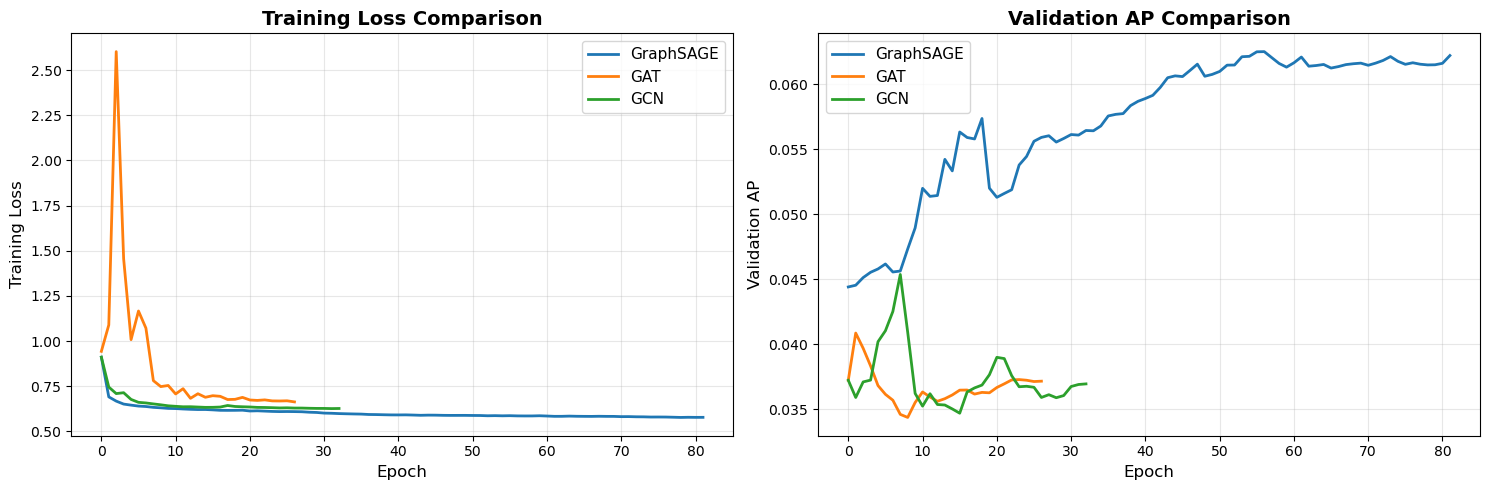

✅ Training history visualization saved!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
ax1 = axes[0]
for name, history in histories.items():
    ax1.plot(history['train_loss'], label=name, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation AP
ax2 = axes[1]
for name, history in histories.items():
    ax2.plot(history['val_ap'], label=name, linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation AP', fontsize=12)
ax2.set_title('Validation AP Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Submissions/training_history2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training history visualization saved!")

## 15. Final Summary

Complete project summary with all results and recommendations.

In [15]:
print("=" * 80)
print("PROJECT SUMMARY - MULTI-LABEL NODE CLASSIFICATION")
print("=" * 80)

print("\n📊 DATASET:")
print(f"  • Nodes: {node_features.shape[0]:,}")
print(f"  • Edges: {edge_index.shape[1]:,}")
print(f"  • Labels: {y.shape[1]}")
print(f"  • Training nodes: {len(train_idx):,}")
print(f"  • Test nodes: {len(test_idx):,}")

print("\n🔧 PREPROCESSING:")
print(f"  • NaN imputation (median)")
print(f"  • Feature standardization")
print(f"  • Advanced degree features (+4 dims: in/out/total/ratio)")
print(f"  • Label reuse: DISABLED (no data leakage)")
print(f"  • Final feature dimension: {in_channels}")

print("\n🤖 MODELS TRAINED:")
for name, val_ap in sorted(val_aps.items(), key=lambda x: x[1], reverse=True):
    print(f"  • {name:15s}: Validation AP = {val_ap:.4f}")

print("\n✨ C&S POST-PROCESSING:")
for name, results in sorted(cs_results.items(), 
                           key=lambda x: x[1]['cs_ap'], reverse=True):
    print(f"  • {name:15s}: {results['baseline_ap']:.4f} → "
          f"{results['cs_ap']:.4f} ({results['improvement']:+.4f})")

print(f"\n🏆 FINAL APPROACH: ENSEMBLE OF ALL 3 MODELS")
print(f"  • Strategy: Average predictions from GraphSAGE + GAT + GCN")
print(f"  • Post-processing: C&S applied to each model before ensembling")
print(f"  • Best individual model: {best_cs_model}")
print(f"  • Best validation AP (with C&S): {cs_results[best_cs_model]['cs_ap']:.4f}")
print(f"  • Ensemble benefit: Reduces variance, more robust predictions")

print("\n📁 OUTPUT FILES:")
print(f"  • Submission: Submissions/final_submission.csv")
print(f"  • Visualization: Submissions/training_history.png")

print("\n💡 KEY TECHNIQUES USED:")
print("  ✓ Ensemble learning (3 different GNN architectures)")
print("  ✓ 3-layer GCN with batch normalization")
print("  ✓ Correct-and-Smooth post-processing (vectorized, GPU-accelerated)")
print("  ✓ Advanced degree features (in/out/total/ratio)")
print("  ✓ Weighted BCE loss (class imbalance)")
print("  ✓ Early stopping + learning rate scheduler")

print("\n" + "=" * 80)
print("PROJECT COMPLETE! 🎉")
print("=" * 80)

PROJECT SUMMARY - MULTI-LABEL NODE CLASSIFICATION

📊 DATASET:
  • Nodes: 19,765
  • Edges: 1,554,790
  • Labels: 305
  • Training nodes: 5,046
  • Test nodes: 3,365

🔧 PREPROCESSING:
  • NaN imputation (median)
  • Feature standardization
  • Advanced degree features (+4 dims: in/out/total/ratio)
  • Label reuse: DISABLED (no data leakage)
  • Final feature dimension: 41

🤖 MODELS TRAINED:
  • GraphSAGE      : Validation AP = 0.0625
  • GCN            : Validation AP = 0.0454
  • GAT            : Validation AP = 0.0409

✨ C&S POST-PROCESSING:
  • GAT            : 0.0409 → 0.1122 (+0.0714)
  • GCN            : 0.0454 → 0.0648 (+0.0195)
  • GraphSAGE      : 0.0625 → 0.0632 (+0.0006)

🏆 FINAL APPROACH: ENSEMBLE OF ALL 3 MODELS
  • Strategy: Average predictions from GraphSAGE + GAT + GCN
  • Post-processing: C&S applied to each model before ensembling
  • Best individual model: GAT
  • Best validation AP (with C&S): 0.1122
  • Ensemble benefit: Reduces variance, more robust predictions

📁 